In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from rdkit import Chem
from openbabel import pybel
from collections import defaultdict
from tqdm import tqdm
import os
import matplotlib
import matplotlib.pylab as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import random
import torch
from torch_geometric.data import Data
import numpy as np
import pickle

In [3]:
import sys
sys.path.append('../evaluation/')

In [4]:
from utils_eval import build_pdb_dict, group_by, extract_selected_pp, compute_target, process_one
from data_processing.ligand import Ligand
from data_processing.utils import sample_probability
from data_processing.utils import ATOM_TYPE_MAPPING, PP_TYPE_MAPPING, ATOM_FAMILIES, MAP_ATOM_TYPE_AROMATIC_TO_INDEX
from data_processing.paired_data import CombinedSparseGraphDataset

In [5]:
import py3Dmol
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, Image
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.ipython_useSVG = True
IPythonConsole.molSize = 600, 600

In [6]:
raw_data_path = '../../data/cleaned_crossdocked_data/raw'

pdb_dict, pdb_rev_dict = build_pdb_dict(raw_data_path)

In [15]:
# ligand_filename = '1ywn_A_rec_1ywn_lif_lig_tt_docked_0.sdf'
# ligand_filename = '4b81_B_rec_4ara_c56_lig_tt_min_0.sdf'
# ligand_filename = '3fu5_A_rec_5ni6_dj3_lig_tt_min_0.sdf'
# ligand_filename = '1lhu_A_rec_1lhn_aon_lig_tt_min_0.sdf'
# ligand_filename = '5hbh_A_rec_5idn_6a7_lig_tt_min_0.sdf'
# ligand_filename = '4b84_A_rec_4b84_z5k_lig_tt_min_0.sdf'
# ligand_filename = '4yyz_B_rec_3ey4_352_lig_tt_docked_12.sdf'
# ligand_filename = '5aen_A_rec_5ni2_dj3_lig_tt_min_0.sdf'
# ligand_filename = '3d3e_B_rec_4ijw_1eq_lig_tt_min_0.sdf'
# ligand_filename = '3ey4_C_rec_4k1l_sff_lig_tt_min_0.sdf'
# ligand_filename = '4h7c_A_rec_3r58_nps_lig_tt_min_0.sdf'

# ligand_filename = '3hfg_A_rec_3hfg_17r_lig_tt_min_0.sdf'
# ligand_filename = '3ey4_C_rec_5pgu_8k4_lig_tt_min_0.sdf'
# ligand_filename = '5ni2_A_rec_5aen_dp8_lig_tt_min_0.sdf'
# ligand_filename = '3fu5_A_rec_5ni6_dj3_lig_tt_min_0.sdf'
# ligand_filename = '4yyz_B_rec_2ilt_nn1_lig_tt_min_0.sdf'
# ligand_filename = '4bnn_A_rec_4bnm_tcu_lig_tt_min_0.sdf'
# ligand_filename = '4yvx_A_rec_1s2a_imn_lig_tt_min_0.sdf'
# ligand_filename = '3czr_B_rec_4bb5_hd2_lig_tt_min_0.sdf'
# ligand_filename = '3czr_A_rec_2ilt_nn1_lig_tt_min_0.sdf'
# ligand_filename = '4b84_A_rec_4btl_5gz_lig_tt_min_0.sdf'
# ligand_filename = '3fue_A_rec_3ftv_11x_lig_tt_min_0.sdf'
# ligand_filename = '4bnk_B_rec_4d44_ja3_lig_tt_min_0.sdf'
# ligand_filename = '3qqp_B_rec_4k1l_sff_lig_tt_min_0.sdf'
# ligand_filename = '4wdu_A_rec_3r94_flr_lig_tt_min_0.sdf'
# ligand_filename = '4alj_A_rec_4bnf_pv4_lig_tt_docked_0.sdf'
# ligand_filename = '1ejj_A_rec_1o99_2pg_lig_tt_docked_0.sdf'
# ligand_filename = '4h96_B_rec_4h95_06u_lig_tt_min_0.sdf'
# ligand_filename = '2oa6_D_rec_4kvi_1sv_lig_tt_min_0.sdf'
# ligand_filename = '4hx5_B_rec_3bzu_a21_lig_tt_min_0.sdf'
# ligand_filename = '5pgy_D_rec_3bzu_a21_lig_tt_min_0.sdf'
# ligand_filename = '5pgv_A_rec_3bzu_a21_lig_tt_min_0.sdf'
# ligand_filename = '4kux_B_rec_4kvw_jf4_lig_tt_min_0.sdf'
# ligand_filename = '4bnk_B_rec_4bnl_w1g_lig_tt_min_0.sdf'
# ligand_filename = '4b82_B_rec_4ara_c56_lig_tt_min_0.sdf'
# ligand_filename = '4pm0_A_rec_4y2b_epk_lig_tt_min_0.sdf'
# ligand_filename = '4ms6_A_rec_3fuh_5h1_lig_tt_min_0.sdf'
# ligand_filename = '5ivg_B_rec_4kvy_jf1_lig_tt_docked_9.sdf'
# ligand_filename = '3r8h_A_rec_3r8h_zom_lig_tt_min_0.sdf'
# ligand_filename = '1aoe_A_rec_3qlr_qlr_lig_tt_docked_4.sdf'
# ligand_filename = '2ilt_A_rec_3ey4_352_lig_tt_min_0.sdf'
# ligand_filename = '2g1q_A_rec_1x88_nat_lig_tt_min_0.sdf'
# ligand_filename = '5imp_B_rec_4kwd_jf2_lig_tt_min_0.sdf'
# ligand_filename = '4d45_A_rec_4ali_tcl_lig_tt_min_0.sdf'
# ligand_filename = '5ivg_B_rec_4kvw_jf4_lig_tt_min_0.sdf'
# ligand_filename = '2rbe_C_rec_3byz_h11_lig_tt_min_0.sdf'
# ligand_filename = '2whr_A_rec_3zlv_hi6_lig_tt_min_0.sdf'  
# ligand_filename = '4hmn_A_rec_3ufy_npx_lig_tt_min_0.sdf'
# ligand_filename = '4h7c_A_rec_3r6i_jms_lig_tt_min_0.sdf'
# ligand_filename = '1pha_A_rec_1phg_myt_lig_tt_min_0.sdf'
# ligand_filename = '1phd_A_rec_1phg_myt_lig_tt_min_0.sdf'
# ligand_filename = '1phg_A_rec_1phg_myt_lig_tt_min_0.sdf'
# ligand_filename = '1phg_A_rec_1phe_piy_lig_tt_min_0.sdf'
# ligand_filename = '1p2y_A_rec_1phg_myt_lig_tt_min_0.sdf'
# ligand_filename = '1p2y_A_rec_1phe_piy_lig_tt_min_0.sdf'
# ligand_filename = '5lgq_D_rec_4ikp_4ik_lig_tt_docked_1.sdf'
# ligand_filename = '1c8j_A_rec_1p2y_nct_lig_tt_min_0.sdf'

# ligand_filename = '1l5l_A_rec_1l4l_xyd_lig_tt_min_0.sdf'
# ligand_filename = '4kqg_A_rec_1l4l_xyd_lig_tt_min_0.sdf'
# ligand_filename = '1jhy_A_rec_1l4f_150_lig_tt_min_0.sdf'
# ligand_filename = '4ws4_A_rec_4wpl_ura_lig_tt_min_0.sdf'

# ligand_filename = '4l0s_A_rec_5al5_jl9_lig_tt_min_0.sdf'

# ligand_filename = '2pg2_A_rec_2wog_zzd_lig_tt_min_0.sdf'

# ligand_filename = '4yur_A_rec_3cok_anp_lig_tt_min_0.sdf'

# ligand_filename = '3ny8_A_rec_4ldo_ale_lig_tt_docked_4.sdf'
# ligand_filename = '5bzf_A_rec_4np2_2l1_lig_tt_min_0.sdf'
# ligand_filename = '4mrg_A_rec_5bzf_4x3_lig_tt_docked_2.sdf'
# ligand_filename = '4mrg_A_rec_5bzg_4x6_lig_tt_min_0.sdf'

# ligand_filename = '1k4h_A_rec_1p0b_pq0_lig_tt_docked_0.sdf'

# ligand_filename = '4xud_A_rec_5lsa_dnc_lig_tt_docked_2.sdf'  # good
# ligand_filename = '4xue_B_rec_5lsa_dnc_lig_tt_docked_10.sdf' # good
# ligand_filename = '4xuc_A_rec_5lsa_dnc_lig_tt_min_0.sdf'  # good
# ligand_filename = '4xuc_A_rec_5lsa_dnc_lig_tt_docked_7.sdf'

# ligand_filename = '1eoc_A_rec_2buz_4nc_lig_tt_docked_4.sdf'  # okay
# ligand_filename = '2bur_A_rec_1eoc_4nc_lig_tt_min_0.sdf'
# ligand_filename = '1eob_A_rec_2buu_4nc_lig_tt_min_0.sdf'
# ligand_filename = '2buu_A_rec_1eoc_4nc_lig_tt_min_0.sdf'

# a lot of h bond and hydro
# ligand_filename = '3afr_A_rec_3vtb_tka_lig_tt_min_0.sdf'
# ligand_filename = '3afr_A_rec_4ynk_yw2_lig_tt_min_0.sdf'
# ligand_filename = '3afr_A_rec_3wt7_ya2_lig_tt_min_0.sdf'
# have one positive ion
# ligand_filename = '5lgq_D_rec_5k8v_6re_lig_tt_min_0.sdf'
# aromatic + h bond (but conflict)
# ligand_filename = '1cp4_A_rec_1phf_pim_lig_tt_min_0.sdf'

# ligand_filename = '3afr_A_rec_3vtb_tka_lig_tt_min_0.sdf'
# ligand_filename = '3afr_A_rec_3vtb_tka_lig_tt_min_0.sdf'

# ligand_filename = '5ehq_A_rec_1j06_ae3_lig_tt_min_0.sdf'

# ligand_filename = '3occ_C_rec_3occ_dih_lig_tt_min_0.sdf'
ligand_filename = '2xud_A_rec_4a23_c56_lig_tt_min_0.sdf'

In [16]:
# use the modified ligand
# ligand_path = os.path.join('structure_based', ligand_filename.split('.')[0], ligand_filename)

# use the original ligand
ligand_path = os.path.join(raw_data_path, pdb_rev_dict[ligand_filename], ligand_filename)
ligand_path

'../../data/cleaned_crossdocked_data/raw/ACES_MOUSE_32_575_0/2xud_A_rec_4a23_c56_lig_tt_min_0.sdf'

In [17]:
rdmol = Chem.MolFromMolFile(ligand_path, removeHs=False, sanitize=True)
pbmol = next(pybel.readfile("sdf", ligand_path))
try:
    rdmol = Chem.AddHs(rdmol)
    ligand = Ligand(pbmol, rdmol, atom_positions=None, conformer_axis=None, filtering=False, preprocess=False)
    rdmol = ligand.rdmol_noH
except Exception as e:
    print(f'Ligand {ligand_path} init failed')
    print(e)

In [18]:
mol_, highlights = group_by(rdmol, ligand)
# highlights

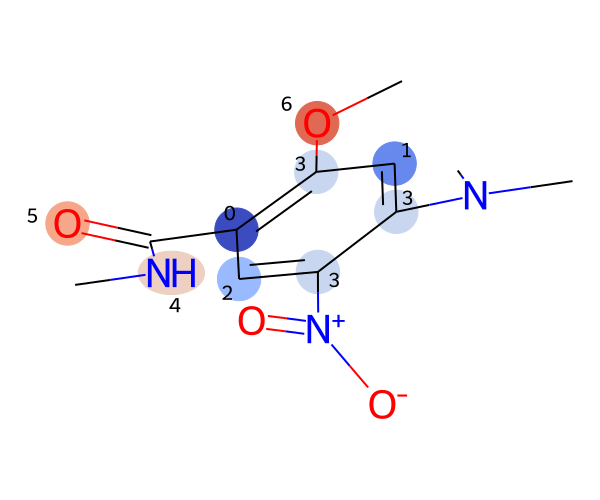

In [19]:
imgsize = (600, 500)
drawer = rdMolDraw2D.MolDraw2DSVG(*imgsize)
drawer.DrawMolecule(mol_, **highlights)
drawer.FinishDrawing()
svg = drawer.GetDrawingText()
display(SVG(svg.replace('svg:','')))

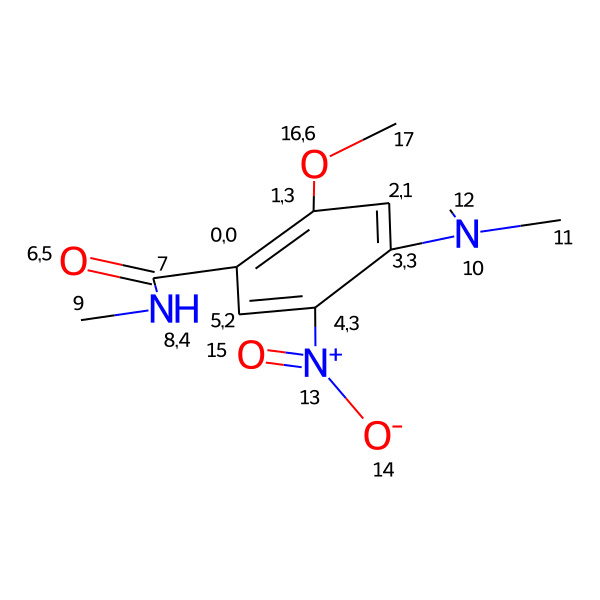

In [20]:
rdmol

In [21]:
for node in ligand.graph.nodes:
    print(node.positions.squeeze())
    print(node.types, node.index)
    atom_indices = list([node.atom_indices]) if type(node.atom_indices)==int else list(sorted(node.atom_indices))
    print(atom_indices)

[31.2043 22.2008  9.7337]
['Hydrophobic'] 0
[0]
[33.3947 23.1169  9.2188]
['Hydrophobic'] 1
[2]
[31.2398 21.5174  8.5103]
['Hydrophobic'] 2
[5]
[32.31625  22.316666  8.864834]
['Aromatic'] 3
[0, 1, 2, 3, 4, 5]
[30.1247 21.602  11.9513]
['HBond_donor', 'HBond_acceptor'] 4
[8]
[28.8623 22.289  10.1231]
['HBond_acceptor'] 5
[6]
[32.3218 23.6798 11.3245]
['HBond_acceptor'] 6
[16]


In [22]:
# 1ywn (pp 2 and 4 should select one)
# selected = [2, 4, 12, 13, 14, 15, 22, 23, 25, 27]

# 1lhn
# selected = [17, 18]
# selected = [i for i in range(len(ligand.graph.nodes))]
# selected

# 4ara (the two oxygen connected with N are not identified by our extraction algorithm, but have interaction with protein)
# 4b82_B_rec_4ara_c56_lig_tt_min_0
# selected = [0, 1, 2, 5, 7, 8, 10]

# 4b84
# selected = [5, 7, 9, 10, 12, 13, 14]

# 3ey4
# selected = [1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14]

# 4k1l
# selected = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13]

# 3r58 (13 is an anion group including 14 and 16, two h bond acceptor/donor)
# selected = [5, 6, 7, 8, 10, 11, 13]
# selected = [5, 6, 7, 8, 10, 11, 14, 16]

# 5ni6
# selected = [5, 6, 9, 10, 11, 13, 14, 17, 18, 19, 20]

# 5ni2
# selected = [5, 6, 9, 10, 11, 13, 14, 17, 18, 19, 20]

# 5idn
# selected = [5, 11, 12, 15, 16]

# 4ijw
# selected = [3, 4, 5, 11, 12, 13, 14, 16, 17, 18, 19]

# 3hfg_A_rec_3hfg_17r_lig_tt_min_0
# selected = [0, 1, 2, 3, 4, 10, 11, 13, 14]

# 3ey4_C_rec_5pgu_8k4_lig_tt_min_0
# selected = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17]

# 5ni2_A_rec_5aen_dp8_lig_tt_min_0
# selected = [9, 10, 11, 12]

# 3fu5_A_rec_5ni6_dj3_lig_tt_min_0
# selected = [5, 6, 9, 10, 11, 13, 14, 17, 18, 19, 20]

# 4yyz_B_rec_2ilt_nn1_lig_tt_min_0
# 17 and 18 are two halogen groups, but in the interaction map, they should be hydrophobic groups
# selected = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 17, 18]

# 4bnn_A_rec_4bnm_tcu_lig_tt_min_0
# selected = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 18]

# 4yvx_A_rec_1s2a_imn_lig_tt_min_0
# 20 is a halogen, but should be hydrophobic
# selected = [0, 1, 2, 3, 5, 13, 14, 16, 18, 20]

# 3czr_B_rec_4bb5_hd2_lig_tt_min_0
# selected = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 17, 18, 20, 21, 22]

# 3czr_A_rec_2ilt_nn1_lig_tt_min_0
# 17 and 18 are two halogen groups, but in the interaction map, they should be hydrophobic groups
# selected = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 17, 18]

# 4b84_A_rec_4btl_5gz_lig_tt_min_0
# the most important NO2 group is not identified
# selected = [4, 9, 10, 12, 13]

# 3fue_A_rec_3ftv_11x_lig_tt_min_0
# selected = [0, 1, 2, 3, 4, 5, 6, 7, 10, 11]

# 4bnk_B_rec_4d44_ja3_lig_tt_min_0
# selected = [0, 1, 2, 3, 4, 5, 6, 9, 10]

# 3qqp_B_rec_4k1l_sff_lig_tt_min_0
# selected = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13]

# 4wdu_A_rec_3r94_flr_lig_tt_min_0
# 16 and 17 are h bond acceptors but included in 15 (anion)
# selected = [0, 1, 2, 3, 4, 12, 15, 14]

# 4alj_A_rec_4bnf_pv4_lig_tt_docked_0
# selected = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 14]

# 1ejj_A_rec_1o99_2pg_lig_tt_docked_0
# 0 and 1 are anion groups that include many h bond donors/acceptors
# selected = [0, 1, 3]
# selected = [2, 3, 4, 5, 6, 7, 8]

# 4h96_B_rec_4h95_06u_lig_tt_min_0
# selected = [3, 4, 6, 7, 8, 9, 10, 11, 17, 19, 20, 21, 22]

# 2oa6_D_rec_4kvi_1sv_lig_tt_min_0
# selected = [0, 1, 2, 3, 4, 5, 6, 7, 9]

# 4hx5_B_rec_3bzu_a21_lig_tt_min_0
# 5pgy_D_rec_3bzu_a21_lig_tt_min_0
# 5pgv_A_rec_3bzu_a21_lig_tt_min_0
# selected = [0, 1, 7, 8, 9, 10]

# 4kux_B_rec_4kvw_jf4_lig_tt_min_0
# TODO: should be 10 rather than 9
# selected = [5, 7, 8, 9, 11]

# 4bnk_B_rec_4bnl_w1g_lig_tt_min_0
# selected = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 14]

# 4pm0_A_rec_4y2b_epk_lig_tt_min_0
# selected = [1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13]

# 4ms6_A_rec_3fuh_5h1_lig_tt_min_0
# selected = [0, 1, 2, 3, 5, 6]

# 5ivg_B_rec_4kvy_jf1_lig_tt_docked_9: only 4 hydro...
# selected = [1, 3, 9, 10]

# 3r8h_A_rec_3r8h_zom_lig_tt_min_0: has both aromatic and h bond
# selected = [2, 10, 11]

# 1aoe_A_rec_3qlr_qlr_lig_tt_docked_4
# selected = [2, 5, 6, 7, 8, 9, 13, 14, 15]

# 2ilt_A_rec_3ey4_352_lig_tt_min_0
# selected = [0, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13]

# 2g1q_A_rec_1x88_nat_lig_tt_min_0: hydro + h bond
# selected = [1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13]

# 5imp_B_rec_4kwd_jf2_lig_tt_min_0
# selected = [1, 3, 5, 10]

# 4d45_A_rec_4ali_tcl_lig_tt_min_0
# selected = [0, 1, 2, 3, 4, 5, 8]

# 5ivg_B_rec_4kvw_jf4_lig_tt_min_0
# selected = [5, 7, 8, 10]

# 2rbe_C_rec_3byz_h11_lig_tt_min_0
# selected = [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13]

# 2whr_A_rec_3zlv_hi6_lig_tt_min_0: few hydro. three h bond
# selected = [3, 4, 5]

# 4hmn_A_rec_3ufy_npx_lig_tt_min_0: hydro + aromatic + h bond
# selected = [10, 11, 12, 14, 16]

# 4h7c_A_rec_3r6i_jms_lig_tt_min_0
# selected = [1, 4, 5, 6, 7, 8, 9, 12]

# 1pha_A_rec_1phg_myt_lig_tt_min_0
# 1phd_A_rec_1phg_myt_lig_tt_min_0
# 1phg_A_rec_1phg_myt_lig_tt_min_0
# 1p2y_A_rec_1phg_myt_lig_tt_min_0
# 9 and 11 conflict
# selected = [1, 6, 7, 8, 9, 11]
# selected = [1, 6, 7, 8, 9]
# selected = [1, 6, 7, 8, 11]

# 1phg_A_rec_1phe_piy_lig_tt_min_0: wrong!! forgot 0. 6 and 8,9 conflict
# selected = [0, 1, 2, 3, 4, 5, 6]
# selected = [6, 7]

# 1p2y_A_rec_1phe_piy_lig_tt_min_0
# selected = [0, 1, 2, 3, 4, 5, 6]

# 5lgq_D_rec_4ikp_4ik_lig_tt_docked_1
# selected = [0, 1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 14, 15, 17]

# 1c8j_A_rec_1p2y_nct_lig_tt_min_0
# selected = [4, 5]

# 1l5l_A_rec_1l4l_xyd_lig_tt_min_0
# 4kqg_A_rec_1l4l_xyd_lig_tt_min_0
# selected = [7, 8]

# 1jhy_A_rec_1l4f_150_lig_tt_min_0
# selected = [4, 6, 7, 8]

# 4ws4_A_rec_4wpl_ura_lig_tt_min_0
# selected = [1, 4, 5]

# 4l0s_A_rec_5al5_jl9_lig_tt_min_0
# selected = [1, 2, 8, 13]

# 2pg2_A_rec_2wog_zzd_lig_tt_min_0
# selected = [18, 19, 20, 22, 23, 24]

# 4yur_A_rec_3cok_anp_lig_tt_min_0
# selected = [1, 3, 4, 5, 6, 10, 14, 16]

# 3ny8_A_rec_4ldo_ale_lig_tt_docked_4
# selected = [5, 6, 7, 8]

# 4mrg_A_rec_5bzf_4x3_lig_tt_docked_2
# selected = [7, 9]

# 1k4h_A_rec_1p0b_pq0_lig_tt_docked_0
# selected = [2, 7, 9, 10]

# '4xud_A_rec_5lsa_dnc_lig_tt_docked_2.sdf'  # good
# ligand_filename = '4xue_B_rec_5lsa_dnc_lig_tt_docked_10.sdf' # good
# ligand_filename = '4xuc_A_rec_5lsa_dnc_lig_tt_min_0.sdf'  # good
# selected = [2, 4]

# ligand_name = '1eoc_A_rec_2buz_4nc_lig_tt_docked_4'  # okay
# selected = [3, 4, 5, 7]

# ligand_name = '2bur_A_rec_1eoc_4nc_lig_tt_min_0'  # okay
# ligand_name = '1eob_A_rec_2buz_4nc_lig_tt_min_0'  # okay
# ligand_name = '1eoc_A_rec_1eoc_4nc_lig_tt_min_0'  # okay
# ligand_name = '2buq_A_rec_2buz_4nc_lig_tt_min_0'  # okay
# ligand_name = '1eoc_A_rec_2buz_4nc_lig_tt_min_0'  # okay
# ligand_name = '2bur_A_rec_2buz_4nc_lig_tt_min_0'  # okay
# ligand_name = '1eob_A_rec_2buu_4nc_lig_tt_min_0'  # not so good
# ligand_name = '2buu_A_rec_1eoc_4nc_lig_tt_min_0'  # okay
# selected = [3, 5]

# 5ehq_A_rec_1j06_ae3_lig_tt_min_0
# selected = [1, 2]

# 2xud_A_rec_4a23_c56_lig_tt_min_0
selected = [3, 4, 5, 6]

In [23]:
selected_pp = [ligand.graph.nodes[i] for i in selected]
selected_pp

[LigandNode(3)['Aromatic'],
 LigandNode(4)['HBond_donor', 'HBond_acceptor'],
 LigandNode(5)['HBond_acceptor'],
 LigandNode(6)['HBond_acceptor']]

In [38]:
aromatic = True
data = process_one(aromatic, rdmol, selected_pp, filename = ligand_filename.split('.')[0])

In [39]:
if aromatic:
    num_feat_class = max(len(PP_TYPE_MAPPING.keys()), len(MAP_ATOM_TYPE_AROMATIC_TO_INDEX.keys()))
else:
    num_feat_class = max(len(PP_TYPE_MAPPING.keys()), len(ATOM_TYPE_MAPPING.keys()))
pp_atom_indices, pp_positions, pp_types, pp_index = extract_selected_pp(selected_pp, num_feat_class)

In [40]:
data

Data(x=[36, 12], pos=[36, 3], target_x=[36, 12], target_pos=[36, 3], Gt_mask=[36], ligand_name='2xud_A_rec_4a23_c56_lig_tt_min_0')

In [41]:
data.target_pos, data.target_x

(tensor([[32.3162, 22.3167,  8.8648],
         [32.3162, 22.3167,  8.8648],
         [32.3162, 22.3167,  8.8648],
         [32.3162, 22.3167,  8.8648],
         [32.3162, 22.3167,  8.8648],
         [32.3162, 22.3167,  8.8648],
         [28.8623, 22.2890, 10.1231],
         [30.8232, 22.5775, 11.7617],
         [30.1247, 21.6020, 11.9513],
         [30.8232, 22.5775, 11.7617],
         [34.8818, 22.8576,  6.8038],
         [34.8818, 22.8576,  6.8038],
         [34.8818, 22.8576,  6.8038],
         [32.3257, 20.5169,  6.1133],
         [32.3257, 20.5169,  6.1133],
         [32.3257, 20.5169,  6.1133],
         [32.3218, 23.6798, 11.3245],
         [30.8232, 22.5775, 11.7617],
         [32.3162, 22.3167,  8.8648],
         [32.3162, 22.3167,  8.8648],
         [32.3162, 22.3167,  8.8648],
         [32.3162, 22.3167,  8.8648],
         [32.3162, 22.3167,  8.8648],
         [32.3162, 22.3167,  8.8648],
         [28.8623, 22.2890, 10.1231],
         [30.8232, 22.5775, 11.7617],
         [30

In [42]:
conformer = rdmol.GetConformer()
atom_positions = conformer.GetPositions()
atom_positions

array([[31.2043, 22.2008,  9.7337],
       [32.3091, 23.0013, 10.0996],
       [33.3947, 23.1169,  9.2188],
       [33.4181, 22.4481,  7.9888],
       [32.3315, 21.6155,  7.6378],
       [31.2398, 21.5174,  8.5103],
       [28.8623, 22.289 , 10.1231],
       [30.0059, 22.0372, 10.5946],
       [30.1247, 21.602 , 11.9513],
       [28.9673, 21.4353, 12.8142],
       [34.5169, 22.6776,  7.0938],
       [35.8598, 22.8742,  7.6148],
       [34.2686, 23.0211,  5.7028],
       [32.3374, 20.8238,  6.4385],
       [33.2259, 19.7831,  6.2948],
       [31.4138, 20.9438,  5.6067],
       [32.3218, 23.6798, 11.3245],
       [33.4964, 24.2601, 11.8763]])

In [43]:
# # manually add in one pp for 5lsa

# the_pos = torch.tensor(atom_positions[9])
# data.target_pos[9] = the_pos
# data.target_pos[9+14] = the_pos

# # make 8 and 10 in the same group or not?
# the_grp_pos = torch.tensor(np.mean([atom_positions[8], atom_positions[10]], axis=0))
# data.target_pos[8] = the_grp_pos
# data.target_pos[10] = the_grp_pos
# data.target_pos[8+14] = the_grp_pos
# data.target_pos[10+14] = the_grp_pos

# # the_pos2 = torch.tensor(atom_positions[12])
# # data.target_pos[12] = the_pos2
# # data.target_pos[12+14] = the_pos2
# # the_grp_pos = torch.tensor(np.mean([atom_positions[11], atom_positions[13]], axis=0))
# # data.target_pos[11] = the_grp_pos
# # data.target_pos[13] = the_grp_pos
# # data.target_pos[11+14] = the_grp_pos
# # data.target_pos[13+14] = the_grp_pos

# the_class = torch.nn.functional.one_hot(torch.tensor([6]), num_classes=num_feat_class).to(torch.float)
# data.target_x[9] = the_class
# data.target_x[9+14] = the_class

# # data.target_x[12] = the_class
# # data.target_x[12+14] = the_class
# print(data.target_pos, data.target_x)

# pp_types = torch.cat([pp_types, the_class])
# pp_positions = torch.cat([pp_positions, the_pos.unsqueeze(0)])
# pp_types, pp_positions

In [44]:
# # manually add in one pp for atom 9 in 2buz/2buu
# the_pos = torch.tensor(atom_positions[9])
# data.target_pos[9] = the_pos
# data.target_pos[9+11] = the_pos
# # the_grp_pos = torch.tensor(np.mean([atom_positions[8], atom_positions[10]], axis=0))
# # data.target_pos[8] = the_grp_pos
# # data.target_pos[10] = the_grp_pos
# # data.target_pos[8+11] = the_grp_pos
# # data.target_pos[10+11] = the_grp_pos

# the_class = torch.nn.functional.one_hot(torch.tensor([6]), num_classes=num_feat_class).to(torch.float)
# data.target_x[9] = the_class
# data.target_x[9+11] = the_class
# print(data.target_pos, data.target_x)

# pp_types = torch.cat([pp_types, the_class])
# pp_positions = torch.cat([pp_positions, the_pos.unsqueeze(0)])
# pp_types, pp_positions

In [45]:
# # manually add in one pp for 1eoc
# the_pos1 = torch.tensor(atom_positions[9])
# the_pos2 = torch.tensor(atom_positions[10])

# the_class = torch.nn.functional.one_hot(torch.tensor([6]), num_classes=num_feat_class).to(torch.float)
# data.target_x[9] = the_class
# data.target_x[9+11] = the_class
# data.target_x[10] = the_class
# data.target_x[10+11] = the_class
# print(data.target_pos, data.target_x)

# pp_types = torch.cat([pp_types, the_class, the_class])
# pp_positions = torch.cat([pp_positions, the_pos1.unsqueeze(0), the_pos2.unsqueeze(0)])
# pp_types, pp_positions

In [46]:
# add hydrophobic pp for atom 9 in 2buz
# the_class = torch.nn.functional.one_hot(torch.tensor([1]), num_classes=num_feat_class).to(torch.float)
# data.target_x[8] = the_class
# data.target_x[8+10] = the_class
# print(data.target_pos, data.target_x)

# pp_types[3] = the_class
# pp_types, pp_positions

In [47]:
# 2xud_A_rec_4a23_c56_lig_tt_min_0
data.target_pos[13] = torch.tensor(atom_positions[13])
data.target_pos[14] = torch.tensor(atom_positions[14])
data.target_pos[15] = torch.tensor(atom_positions[15])
data.target_pos[13+18] = torch.tensor(atom_positions[13])
data.target_pos[14+18] = torch.tensor(atom_positions[14])
data.target_pos[15+18] = torch.tensor(atom_positions[15])

the_class = torch.nn.functional.one_hot(torch.tensor([6]), num_classes=num_feat_class).to(torch.float)
data.target_x[14] = the_class
data.target_x[15] = the_class
data.target_x[14+18] = the_class
data.target_x[15+18] = the_class
print(data.target_pos, data.target_x)

pp_types = torch.cat([pp_types, the_class, the_class])
pp_positions = torch.cat([pp_positions, torch.tensor(atom_positions[14]).unsqueeze(0), torch.tensor(atom_positions[15]).unsqueeze(0)])
pp_types, pp_positions

tensor([[32.3162, 22.3167,  8.8648],
        [32.3162, 22.3167,  8.8648],
        [32.3162, 22.3167,  8.8648],
        [32.3162, 22.3167,  8.8648],
        [32.3162, 22.3167,  8.8648],
        [32.3162, 22.3167,  8.8648],
        [28.8623, 22.2890, 10.1231],
        [30.8232, 22.5775, 11.7617],
        [30.1247, 21.6020, 11.9513],
        [30.8232, 22.5775, 11.7617],
        [34.8818, 22.8576,  6.8038],
        [34.8818, 22.8576,  6.8038],
        [34.8818, 22.8576,  6.8038],
        [32.3374, 20.8238,  6.4385],
        [33.2259, 19.7831,  6.2948],
        [31.4138, 20.9438,  5.6067],
        [32.3218, 23.6798, 11.3245],
        [30.8232, 22.5775, 11.7617],
        [32.3162, 22.3167,  8.8648],
        [32.3162, 22.3167,  8.8648],
        [32.3162, 22.3167,  8.8648],
        [32.3162, 22.3167,  8.8648],
        [32.3162, 22.3167,  8.8648],
        [32.3162, 22.3167,  8.8648],
        [28.8623, 22.2890, 10.1231],
        [30.8232, 22.5775, 11.7617],
        [30.1247, 21.6020, 11.9513],
 

(tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]),
 tensor([[32.3162, 22.3167,  8.8648],
         [30.1247, 21.6020, 11.9513],
         [28.8623, 22.2890, 10.1231],
         [32.3218, 23.6798, 11.3245],
         [33.2259, 19.7831,  6.2948],
         [31.4138, 20.9438,  5.6067]], dtype=torch.float64))

In [48]:
save_path = '../evaluation/structure_based'
# foldername = ligand_filename[ligand_filename.rfind('rec')+4:ligand_filename.rfind('rec')+8]
foldername = ligand_filename.split('.')[0]
save_fn = ligand_filename.split('.')[0] + '_aromatic.pt' if aromatic else ligand_filename.split('.')[0] + '.pt'

In [49]:
os.makedirs(os.path.join(save_path, foldername), exist_ok=True)
torch.save(data, os.path.join(save_path, foldername, save_fn))

In [50]:
pp_info = {
    'pp_types': pp_types, 
    'pp_positions': pp_positions
}

pp_info

{'pp_types': tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]),
 'pp_positions': tensor([[32.3162, 22.3167,  8.8648],
         [30.1247, 21.6020, 11.9513],
         [28.8623, 22.2890, 10.1231],
         [32.3218, 23.6798, 11.3245],
         [33.2259, 19.7831,  6.2948],
         [31.4138, 20.9438,  5.6067]], dtype=torch.float64)}

In [51]:
with open(os.path.join(save_path, foldername, 'pp_info.pkl'), 'wb') as f:
    pickle.dump(pp_info, f)